# Model Comparison


## Imports and Config

In [2]:
from config import *
import torch
from sklearn.metrics import accuracy_score, det_curve
import matplotlib.pyplot as plt

from os.path import join

from models import LeakNetRNN, LeakNetCRNN, LeakNetRAE

from data.dataset import LeakAnomalyDetectionDataset
from data.data_loaders import get_dataloaders, get_classifiers_datasets, get_autoencoders_datasets
from utils import set_device, set_seed, load_model_from_study
from data.visualize import visualize_regression, visualize_classification


import optuna

set_device()
set_seed()

Using device = cpu
Using seed = 42


42

## Load Best Models

In [29]:
dataset = LeakAnomalyDetectionDataset(normal_data_dir=NORMAL_DATA, anomalous_data_dir=ANOMALOUS_DATA)
_, _, classifiers_test_set = get_classifiers_datasets(dataset)
_, _, autoencoders_test_set = get_autoencoders_datasets(dataset)

leaknet_rnn_study = optuna.load_study(study_name="LeakNetRNN", storage="sqlite:///studies.db")
leaknet_crnn_study = optuna.load_study(study_name="LeakNetCRNN", storage="sqlite:///studies.db")
# leaknet_rae_study = optuna.load_study(study_name="LeakNetRAE", storage="sqlite:///studies.db")

rnn_model = load_model_from_study(leaknet_rnn_study)
crnn_model = load_model_from_study(leaknet_crnn_study)
# rae_model = load_model_from_study(leaknet_rae_study)

rnn_model.eval()
crnn_model.eval()
# rae_model.eval()

/home/nikas/.local/lib/python3.10/site-packages/torch/utils/_device.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


LeakNetCRNN(
  (conv): Sequential(
    (0): Conv1d(3, 2, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): LeakNetRNN(
    (rnn): GRU(2, 32, num_layers=2, batch_first=True, dropout=0.10762256036229163)
    (anomaly_head): Sequential(
      (0): Linear(in_features=32, out_features=1, bias=True)
      (1): Sigmoid()
    )
    (distance_head): Linear(in_features=32, out_features=1, bias=True)
  )
)

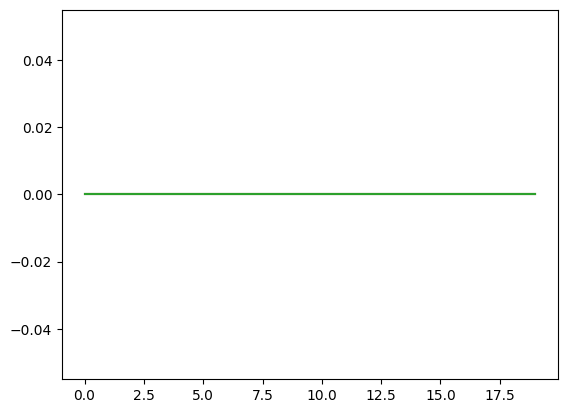

(tensor(0.8941, grad_fn=<SqueezeBackward0>), tensor(38.6160, grad_fn=<SqueezeBackward0>)) tensor(1.)


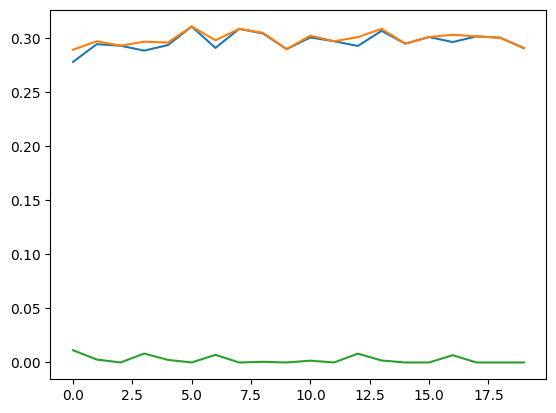

(tensor(0.0727, grad_fn=<SqueezeBackward0>), tensor(40.4805, grad_fn=<SqueezeBackward0>)) tensor(0.)


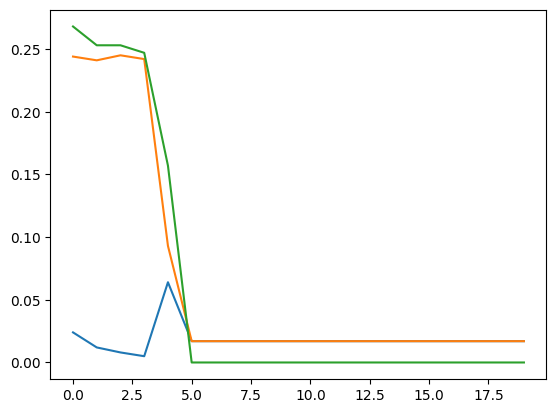

(tensor(0.7294, grad_fn=<SqueezeBackward0>), tensor(38.8262, grad_fn=<SqueezeBackward0>)) tensor(1.)


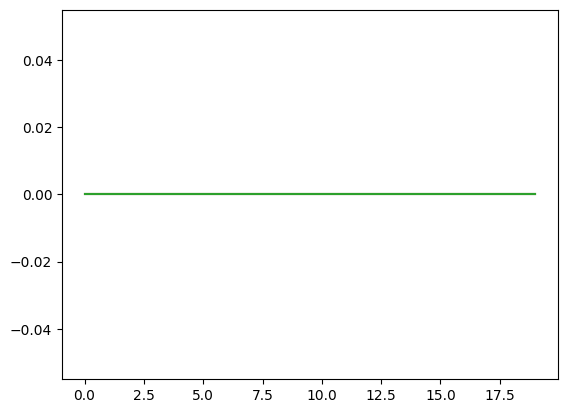

(tensor(0.8941, grad_fn=<SqueezeBackward0>), tensor(38.6160, grad_fn=<SqueezeBackward0>)) tensor(0.)


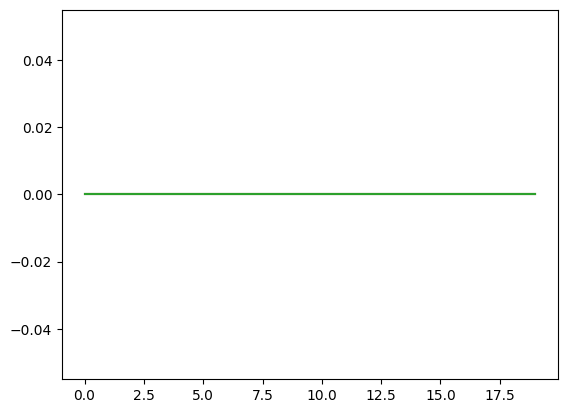

(tensor(0.8941, grad_fn=<SqueezeBackward0>), tensor(38.6160, grad_fn=<SqueezeBackward0>)) tensor(0.)


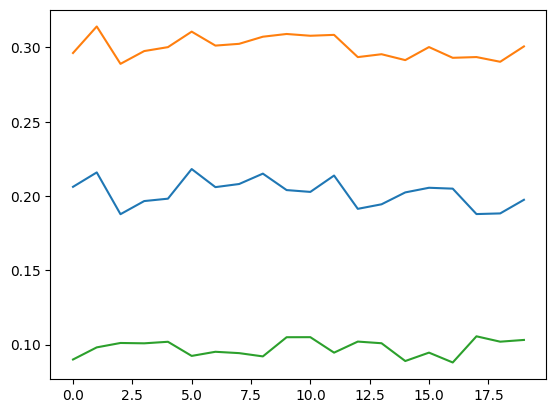

(tensor(0.1344, grad_fn=<SqueezeBackward0>), tensor(40.3038, grad_fn=<SqueezeBackward0>)) tensor(0.)


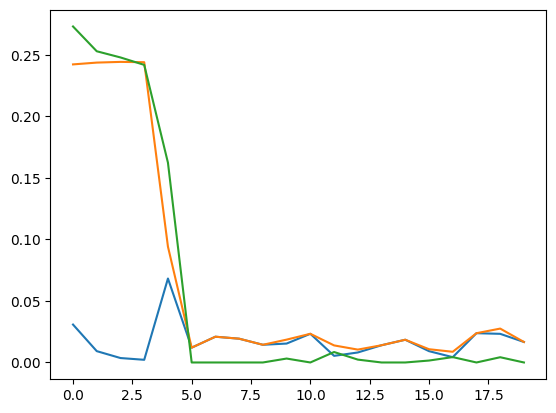

(tensor(0.7322, grad_fn=<SqueezeBackward0>), tensor(38.7607, grad_fn=<SqueezeBackward0>)) tensor(1.)


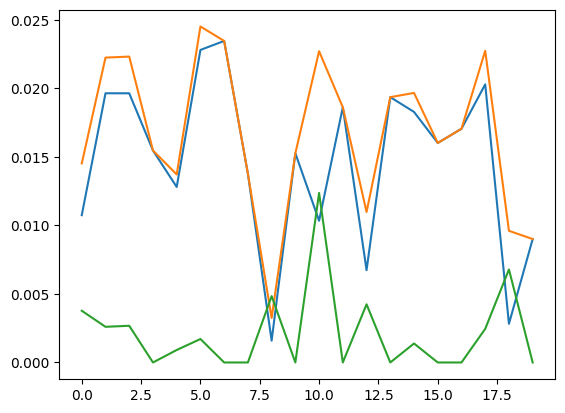

(tensor(0.8783, grad_fn=<SqueezeBackward0>), tensor(38.6770, grad_fn=<SqueezeBackward0>)) tensor(1.)


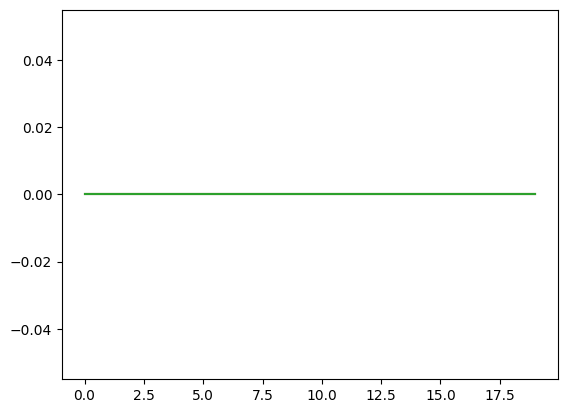

(tensor(0.8941, grad_fn=<SqueezeBackward0>), tensor(38.6160, grad_fn=<SqueezeBackward0>)) tensor(0.)


In [33]:
for x, (y_anomaly, _) in classifiers_test_set:
    plt.plot(x[-100:-80])
    plt.show()
    print(rnn_model(x[-100:-80]), y_anomaly)

## Model Comparisment
Multiple models are tested on the test set, to determine the final best model to use in production.

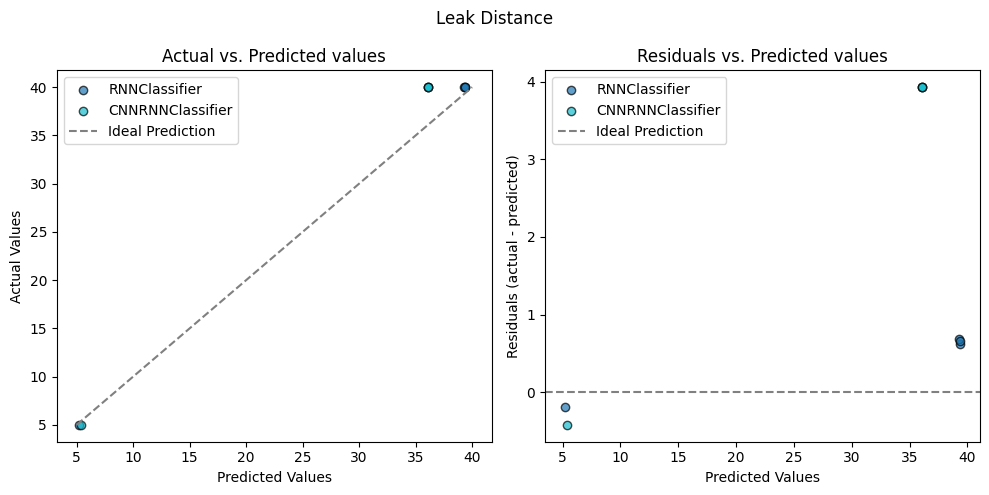

In [108]:
x, (y_anomaly, y_distance) = classifiers_test_set[:]

anomaly_mask = y_anomaly == 1
y_anomaly = y_anomaly.detach().cpu().numpy()

y_distance = torch.masked_select(y_distance, anomaly_mask).detach().cpu().numpy()

distances = []

models = [rnn_model, crnn_model, rae_model]
models_names = [type(x).__name__ for x in models]

for model in models:
    with torch.no_grad():
        anomaly, distance = model.forward(x)
        anomaly = anomaly.detach().cpu().numpy()
        distances.append(torch.masked_select(distance, anomaly_mask).detach().cpu().numpy())
        
        
visualize_regression(y_distance, distances, models_names, title="Leak Distance")

In [ ]:
# False Alarm Rate

# Accuracy


visualize_classification(y_anomalies, [anomalies], [type(model).__name__], title="Leak Classification")

# with torch.no_grad():
#   for x, (y_anomaly, y_distance) in test_loader:
#     anomaly, distance = model.forward(x)
#     fpr, fnr, thresholds = det_curve(y_anomaly, anomaly)
#     print(fpr, fnr, thresholds)

## Serialize best model to production environment

In [ ]:
model = model.to_torchscript()
model.save(os.path.join(MODELS_DIR, type(model).__name__))